In [3]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:

# Pre-process function
def preprocess_image(img):
    img = cv2.resize(img, (256, 256)).astype(np.float32) / 255.0
    img_uint8 = (img * 255).astype(np.uint8)
    smoothed = cv2.medianBlur(img_uint8, 5) / 255.0
    dark = cv2.erode(np.min(smoothed, axis=2), np.ones((15, 15)))
    num_pixels = int(0.001 * dark.size)
    indices = np.argpartition(dark.ravel(), -num_pixels)[-num_pixels:]
    A = np.mean(smoothed.reshape(-1, 3)[indices], axis=0)
    return smoothed, A



In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# U-Net Definition
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.dec1 = nn.Conv2d(96, 32, 3, padding=1)
        self.out = nn.Conv2d(32, 1, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e1 = self.relu(self.enc1(x))
        p1 = self.pool(e1)
        e2 = self.relu(self.enc2(p1))
        u1 = self.up(e2)
        m1 = torch.cat([e1, u1], dim=1)
        d1 = self.relu(self.dec1(m1))
        return self.sigmoid(self.out(d1))


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet()
model.load_state_dict(torch.load("unet_dehaze_2k.pth", map_location=device))
model.to(device)


UNet(
  (enc1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (up): Upsample(scale_factor=2.0, mode='bilinear')
  (dec1): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (out): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [9]:
def dehaze_single_image(input_img_path, model, device):
    import cv2
    import torch
    import numpy as np
    import matplotlib.pyplot as plt

    # === Step 1: Preprocessing ===
    img = cv2.imread(input_img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, (256, 256)).astype(np.float32) / 255.0

    img_uint8 = (img_resized * 255).astype(np.uint8)
    smoothed = cv2.medianBlur(img_uint8, 5).astype(np.float32) / 255.0

    dark = cv2.erode(np.min(smoothed, axis=2), np.ones((15, 15)))
    num_pixels = int(0.001 * dark.size)
    indices = np.argpartition(dark.ravel(), -num_pixels)[-num_pixels:]
    A = np.mean(smoothed.reshape(-1, 3)[indices], axis=0)
    A = A[None, None, :]

    input_tensor = torch.from_numpy(img_resized.transpose(2, 0, 1)).unsqueeze(0).to(device)

    # === Step 2: Model Prediction ===
    model.eval()
    with torch.no_grad():
        t_pred = model(input_tensor)
        t_pred_np = t_pred.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # === Step 3: Dehazing ===
    hazy_np = img_resized
    t_pred_np = np.maximum(t_pred_np, 0.1)
    dehazed = (hazy_np - A) / t_pred_np + A
    dehazed = np.clip(dehazed, 0, 1)

    # === Step 4: Post-processing ===
    dehazed_uint8 = (dehazed * 255).astype(np.uint8)
    lab = cv2.cvtColor(dehazed_uint8, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

    kernel_sharp = np.array([[0, -1, 0],
                             [-1, 5, -1],
                             [0, -1, 0]])
    sharpened = cv2.filter2D(enhanced, -1, kernel_sharp)

    hsv = cv2.cvtColor(sharpened, cv2.COLOR_RGB2HSV).astype(np.float32)
    hsv[...,1] = np.clip(hsv[...,1] * 1.1, 0, 255)
    boosted = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

    # === Step 5: Final Gentle Smoothening ===
    final_result = cv2.bilateralFilter(boosted, d=5, sigmaColor=50, sigmaSpace=50)

    # === Step 6: Display Results ===
    titles = ['Original Hazy', 'Preprocessed', 'Dehazed', 'Final Enhanced']
    images = [img_rgb, smoothed, dehazed, final_result]

    plt.figure(figsize=(14, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    return dehazed, final_result


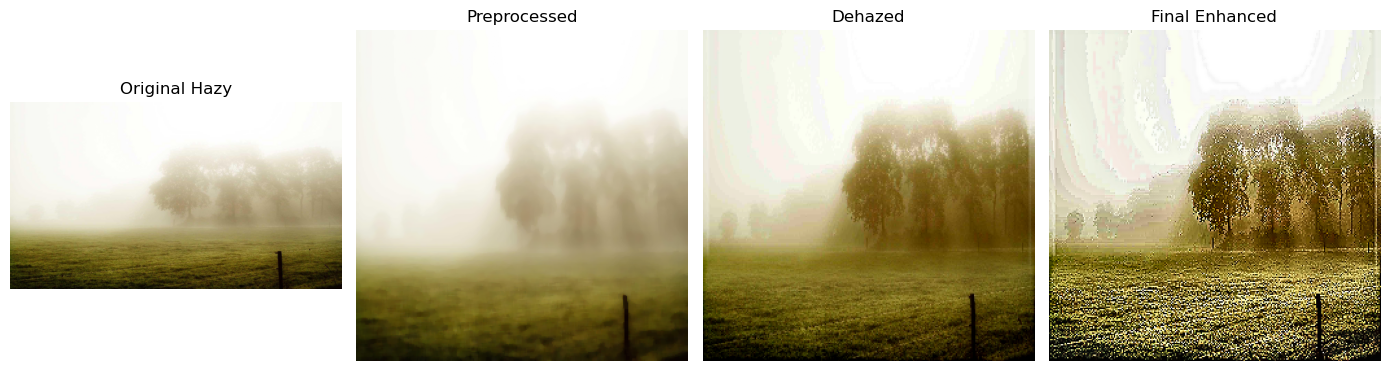

In [10]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\qI8An3.jpg", model, device)


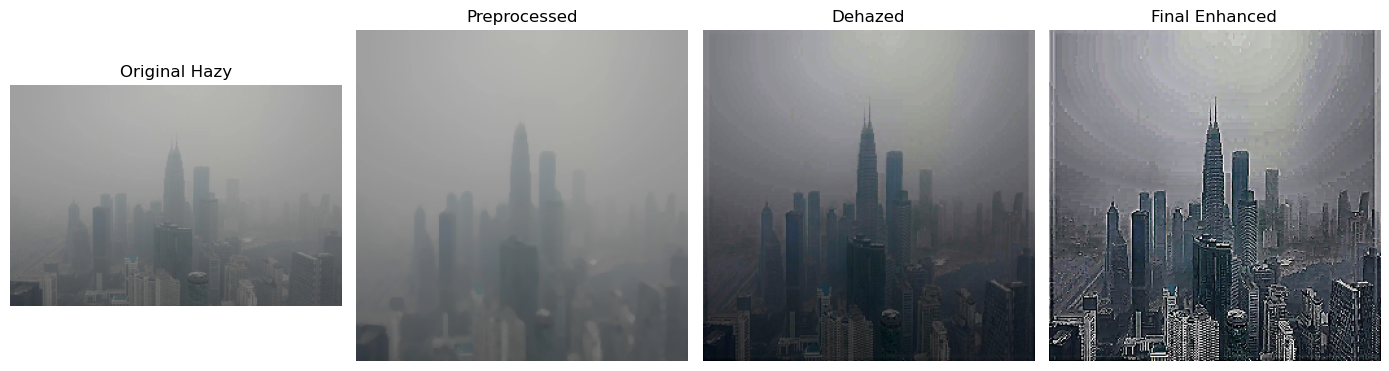

In [11]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\fb539787-gp0sttw5v.webp", model, device)


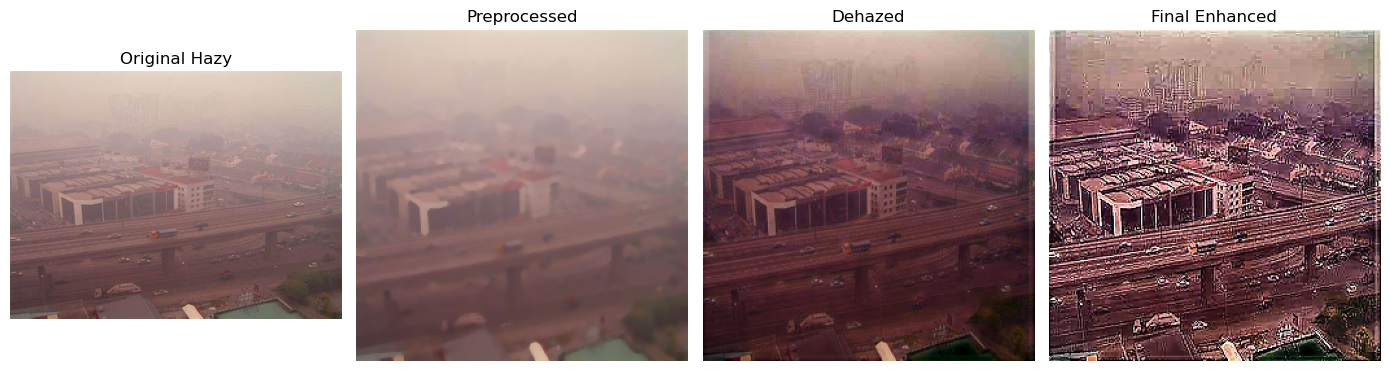

In [12]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\OIP.jpeg", model, device)


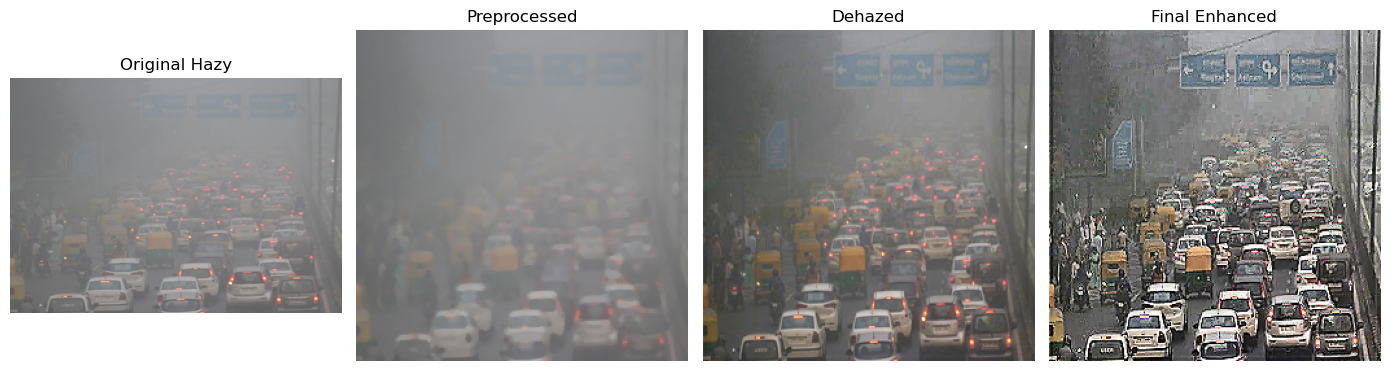

In [16]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\airpollution-1512923988.jpg", model, device)


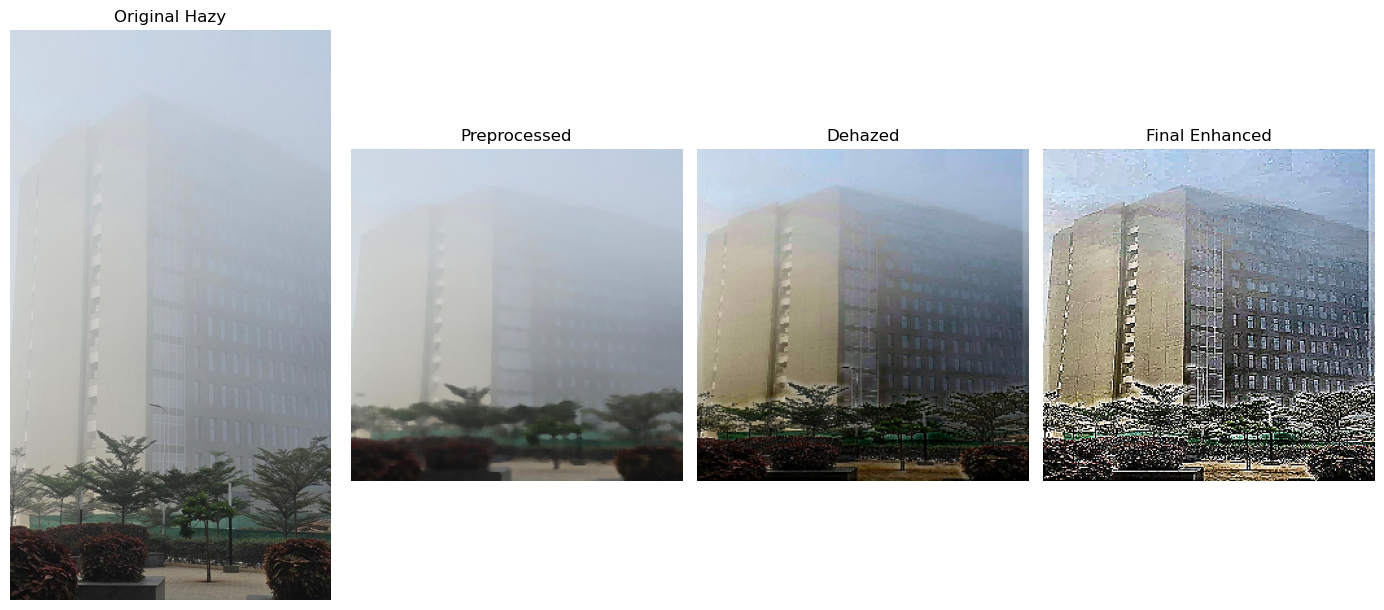

In [21]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\srm.jpg", model, device)


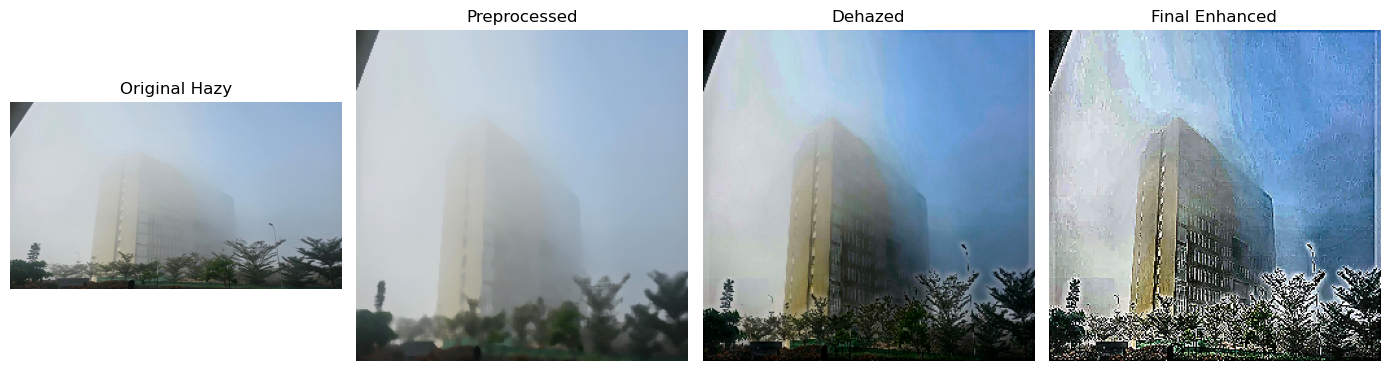

In [23]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\srm1.jpg", model, device)


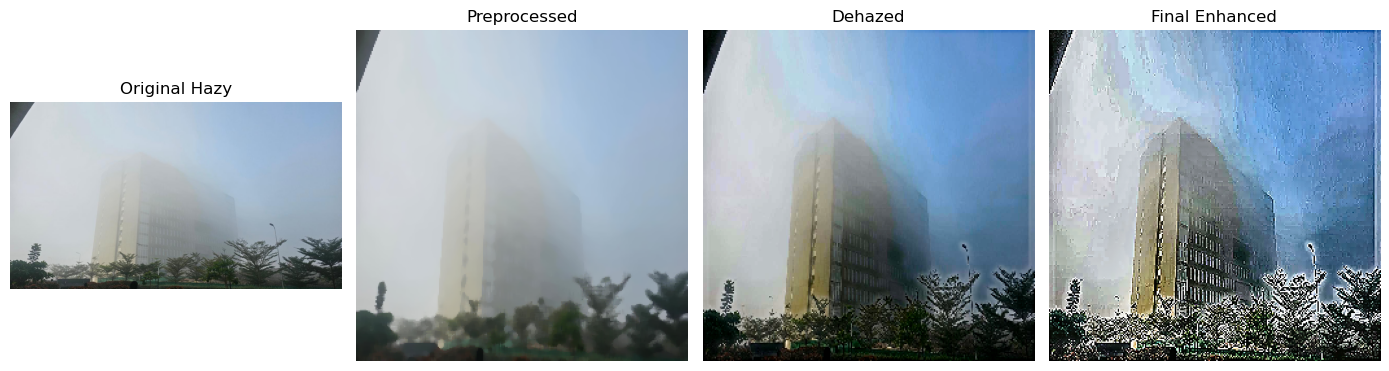

In [25]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\srm2.jpg", model, device)


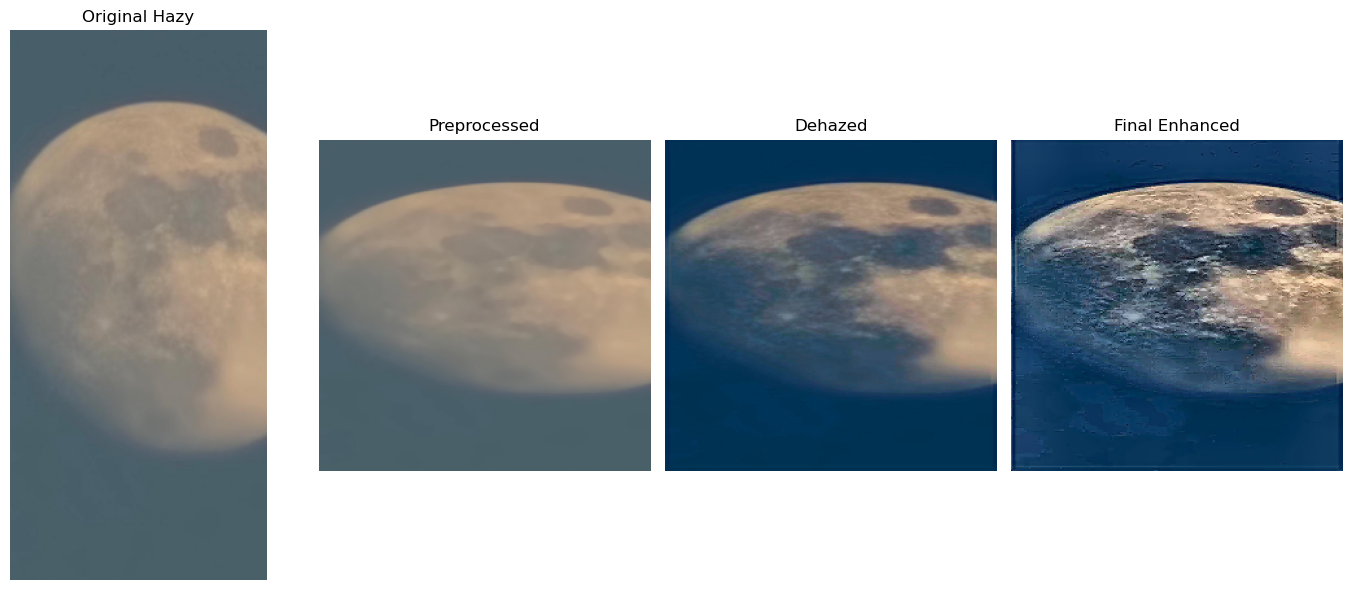

In [27]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\moon1.jpg", model, device)


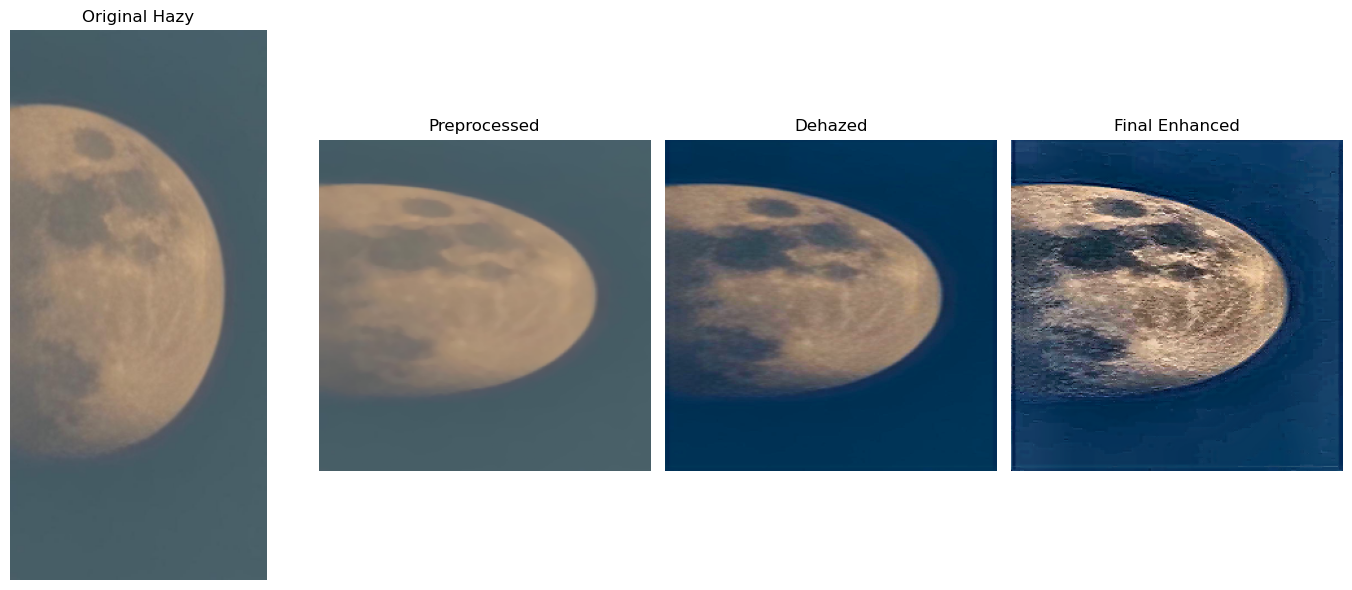

In [29]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\moon2.jpg", model, device)


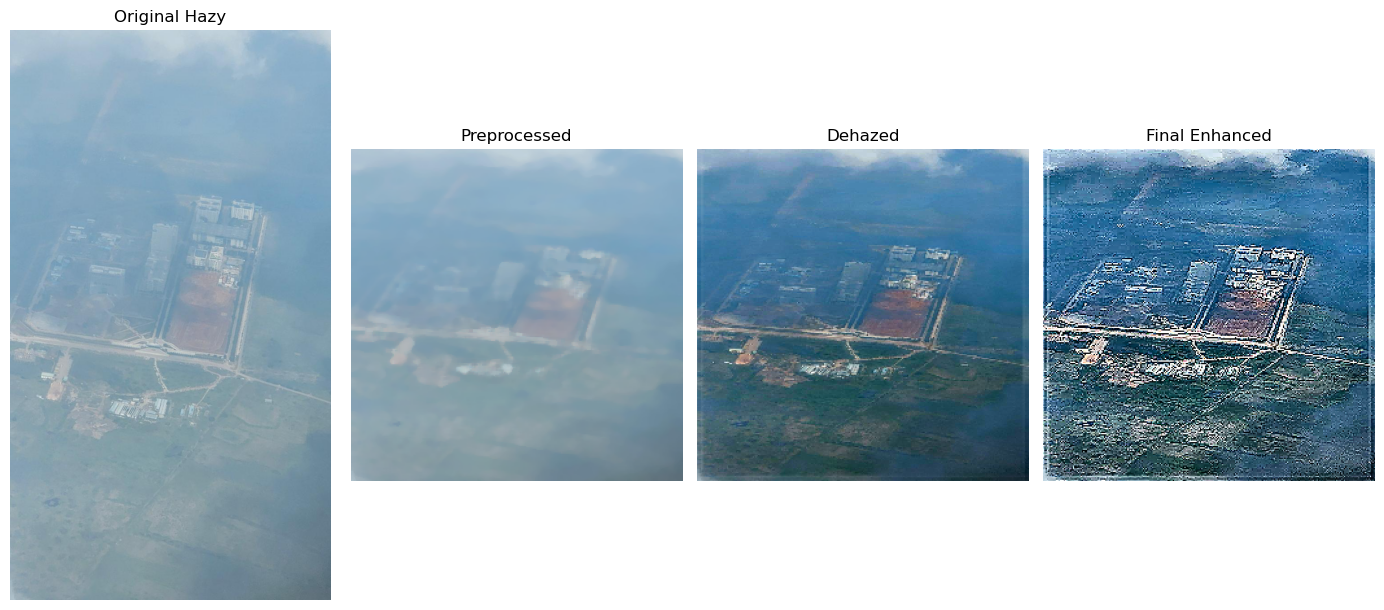

In [31]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\srmair.jpg", model, device)


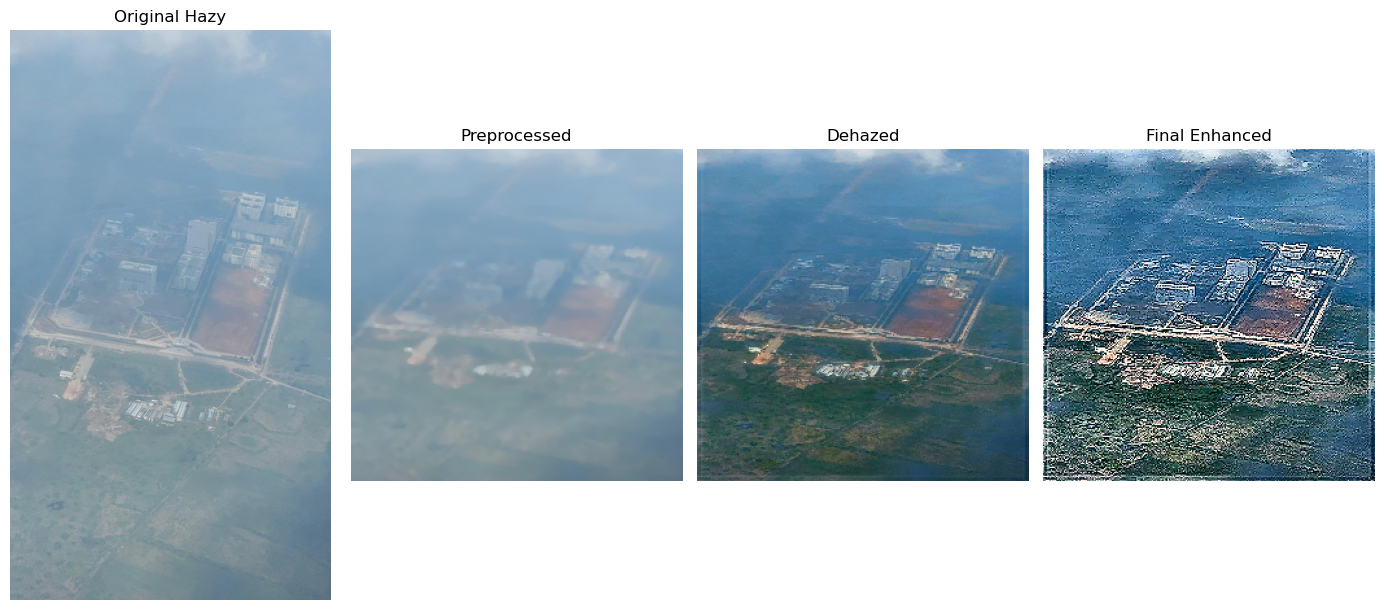

In [33]:
dehazed_img, final_output = dehaze_single_image("C:\\Users\\asus\\Downloads\\dip\\srmair2.jpg", model, device)
